# Import related packages and initialize models

In [10]:
import torch
import mmcv
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot, show_cell_pyplot
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import time
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
from PIL import Image
# Specify the path to checkpoint and config files
config_file = "../configs/OrgSegNet/OrgSeg_PlantCell_768x512.py"
# load the checkpoint of the OrgSegNet
checkpoint_file = "../checkpoints/OrgSegNet_iter_Version1.pth"

# build the model from a config file and a checkpoint file
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
model = init_model(config_file, checkpoint_file, device=device)
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

Loads checkpoint by local backend from path: ../checkpoints/OrgSegNet_iter_Version1.pth


Read in image data and complete preprocessing

In [2]:
image = np.array(Image.open("./demo_images/demo1.tif").resize([768, 512]).convert("RGB"))

rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

input_tensor = input_tensor.to(device)

Modify the model structure to ensure that CAM can output correctly

In [3]:
class SegmentationModelOutputWrapper(nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        self.backbone = model.backbone
        self.head = model.decode_head
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=4)
    def forward(self, x):
        out = self.head(self.backbone(x))
        out = self.upsample(out)
        return out


model2 = SegmentationModelOutputWrapper(model)
output = model2(input_tensor)

In [4]:
# Let's check the output size.
output.shape

torch.Size([1, 5, 512, 768])

Select the category ('background', 'Chloroplast', 'Mitochondria', 'Vacuole', 'Nucleus') for which you want to view CAM results.
</br>
When we choose "Chloroplast", the code should be:
</br>
`car_category = sem_class_to_idx["Chloroplast"]`

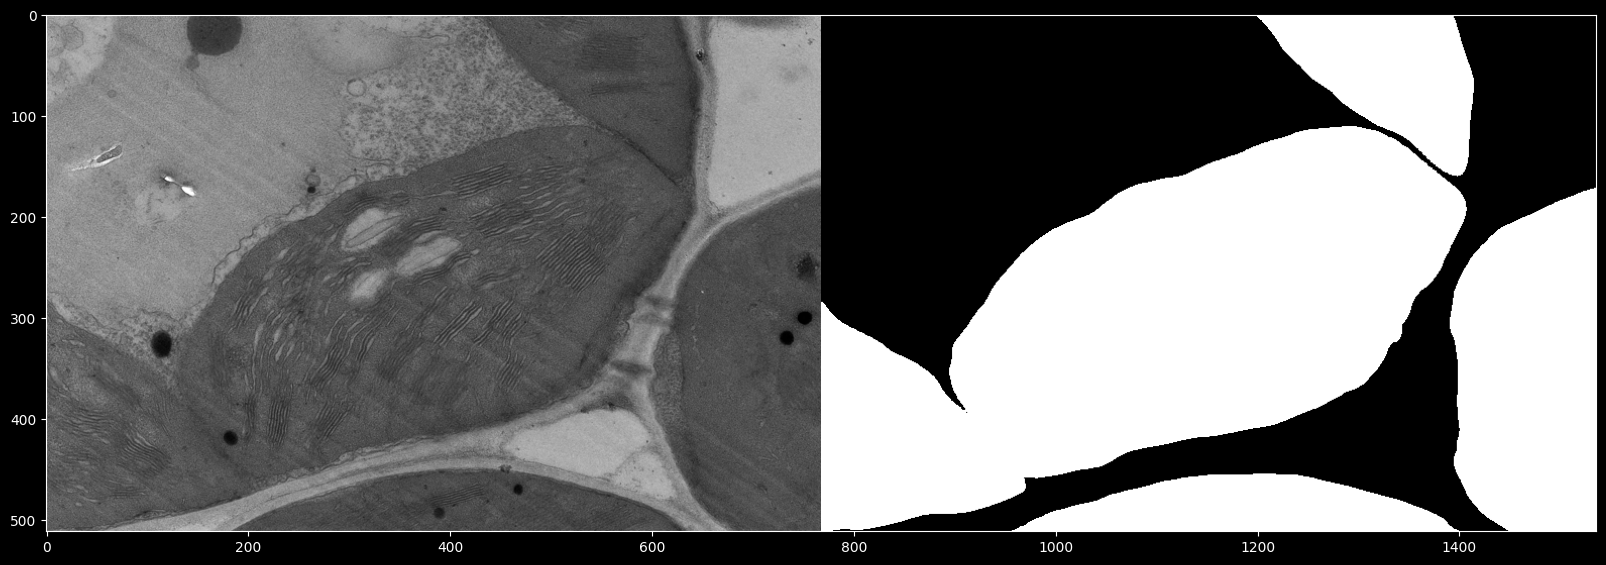

In [5]:
# Apply a simple softmax to generate the mask of model output
# Ensure that each pixel gets the label with the highest probability
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    'background', 'Chloroplast', 'Mitochondria', 'Vacuole', 'Nucleus'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

# select the organelle name here 
car_category = sem_class_to_idx["Chloroplast"]

car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)
both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))

# show the original image and mask image. We can find 
plt.figure(figsize=(20,8))
plt.imshow(both_images)
plt.show()
# Image.fromarray(np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)).resize([4800, 3230]).save(r"/mnt/e/科研文件/NaturePlants返修project/postprocess/mask_beforepost.jpg")

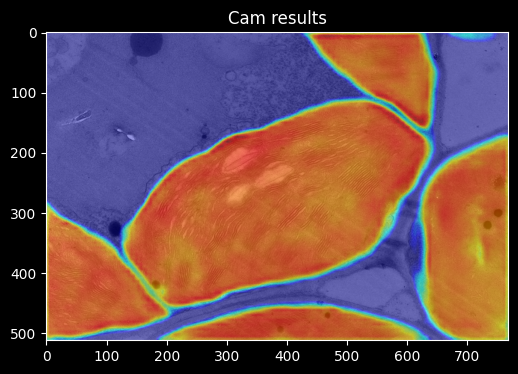

In [6]:
# GradCAM and GradCAMElementWise both can be used
from pytorch_grad_cam import GradCAM, GradCAMElementWise

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        # if torch.cuda.is_available():
        self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


# define the target layer, conv_seg is the fusion layer of OrgSegNet
target_layers = [model2.model.decode_head.conv_seg]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]

with GradCAM(model=model2,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

## Show the CAM results
plt.figure(figsize=(6,4))
plt.title("Cam results")
plt.imshow(cam_image)
plt.show()

Now we need to implement a separation method through scipy

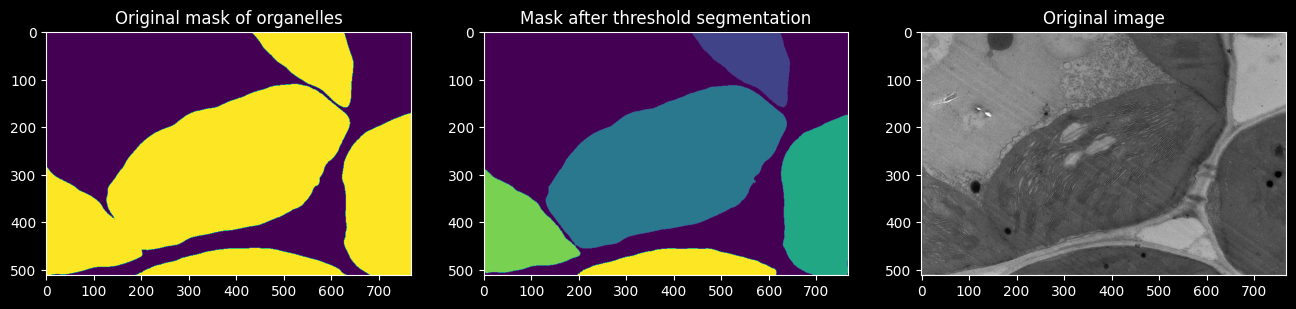

In [7]:
from scipy import ndimage, io
import cv2
# The threshold is between 0 and 1, but it works best around 0.5. Here we set it to 0.52.
threshold = 0.55
split_mask = np.where(grayscale_cam<threshold, 0, 1)
# fill the small hole 
fill_image = ndimage.binary_fill_holes(split_mask, structure=np.ones((15,15))).astype(np.uint8)
# label each instance mask
labeled_image, num_labels = ndimage.label(fill_image)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.title("Original mask of organelles")
plt.imshow(car_mask_float)

plt.subplot(1, 3, 2)
plt.title("Mask after threshold segmentation")
plt.imshow(labeled_image)

plt.subplot(1, 3, 3)
plt.title("Original image")
plt.imshow(rgb_img)

However, some important pixels were missing when we apply the threshold algorithm.
Here, we apply a kind of "Shortest distance matching algorithm". We call it Pixel match.


## Pixel match

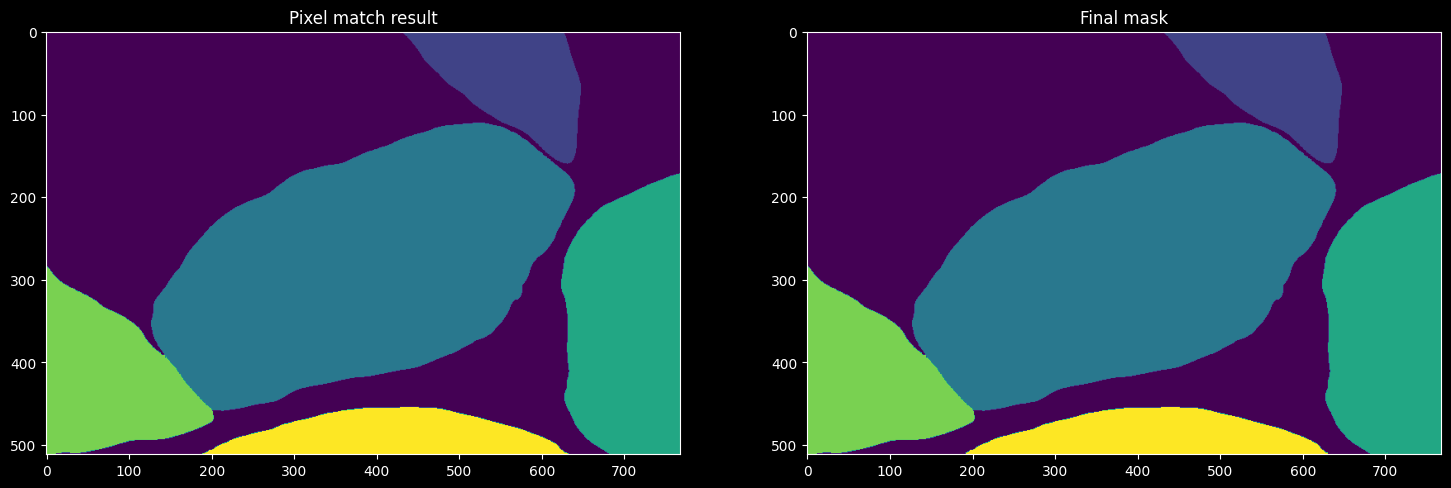

In [8]:
# Initialize a label image
ori_mask = 255*np.array(car_mask_float).astype("uint8")
labeled_mask = labeled_image
pixel_add = ori_mask + labeled_mask

# already know label： such as 1, 2, 3, 4, 5
# we set background pixels as -255  
# The unknow pixels we set as 0
area_grow_image = pixel_add - 255

w, h = area_grow_image.shape
# We create an array to store the coordinate information of unknown points
unknown_pixels_all = []
for x in range(w):
    for y in range(h):
        if area_grow_image[x, y] == 0:
            # 添加坐标
            unknown_pixels_all.append(np.array([x, y]))


import numpy as np
from scipy.spatial.distance import cdist

def find_nearest_pixel(unknown_pixel, known_pixels, labels):
    '''
    This function will find the coordinates and label of the closest known point to an unknown point

    return: The closest known point and its label.
    '''
    distances = cdist([unknown_pixel], known_pixels)
    nearest_index = np.argmin(distances)
    nearest_pixel = known_pixels[nearest_index]
    nearest_label = labels[nearest_index]
    return nearest_pixel, nearest_label

# copy the original label_mask as the temp_mask
# copy the original label_mask as the new_mask
temp_mask = labeled_mask.copy()
new_mask = labeled_mask.copy()
for pix_index in range(len(unknown_pixels_all)):
    # Set the step size in the direction of eight connections
    # Find the nearest known point from eight directions
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    nearest_pixels = []
    nearest_labels = []
    temp_known_all = []
    temp_labels = []
    # Initialize a minimum number of steps (10000) to optimize the time consumption of the algorithm.
    # The shortest distance in each direction will be recorded.
    # If the algorithm walk more than this number of steps in a certain direction, that direction is ignored.
    minium_step = 10000
    for index, direction in enumerate(directions):
        # First find the nearest known point in each of the eight directions, 
        # while the loop stop until a known point in a certain direction is found

        # Initialize the unknow pixel coordinates (x, y) 
        x = unknown_pixels_all[pix_index][0]
        y = unknown_pixels_all[pix_index][1]
        step = 0

        total_step = 0
        while len(temp_known_all) == index:
            step += 1
            # check if the number of steps taken is less than the minimum number of steps
            if step <= minium_step:
                x = x + direction[0]
                y = y + direction[1]

                # Check if the coordinates of the point are out of bounds
                if x<=0 or y<=0:
                    temp_known_all.append([0,0])
                    temp_labels.append(0)

                # If the border has not been reached, continue searching for known points
                elif 0 < x < 512 and 0 < y < 768:
                    current_pixel = np.array([x, y])
                    current_pixel_vaule = temp_mask[x, y]

                    if  current_pixel_vaule> 0:
                        temp_known_all.append(current_pixel)
                        temp_labels.append(current_pixel_vaule)
                        if step <= minium_step:
                            minium_step = step

                # Prevent strange errors from sending the algorithm into an infinite loop
                else:
                    temp_known_all.append([0,0])
                    temp_labels.append(0)

            # If the number of steps the algorithm takes in this direction exceeds the minimum number of steps, 
            # stop the query in this direction
            else:
                temp_known_all.append([0,0])
                temp_labels.append(0)
                
    # Find the nearest known point and coordinates
    nearest_pixel, nearest_label = find_nearest_pixel(current_pixel, temp_known_all, temp_labels)
    nearest_pixels.append(nearest_pixel)
    nearest_labels.append(nearest_label)

    # Map labels of known points to unknown points
    new_mask[unknown_pixels_all[pix_index][0], unknown_pixels_all[pix_index][1]] = np.array(nearest_labels).max()

# let us check the new_mask after Pixel match was applied.
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.title("Pixel match result")
plt.imshow(new_mask)


# Perform an OPEN operation to eliminate possible noise
kernel_size = (3, 3)  # init a kernel size
kernel_shape = cv2.MORPH_RECT  #  init a kernel shape
kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
opened_image = cv2.morphologyEx(np.uint8(new_mask), cv2.MORPH_OPEN, kernel, iterations=1)

# let us check the new_mask after OPEN operation was applied.
plt.subplot(1,2,2)
plt.title("Final mask")
plt.imshow(opened_image)
plt.show()

Let's compare the labels before and after postprocessing

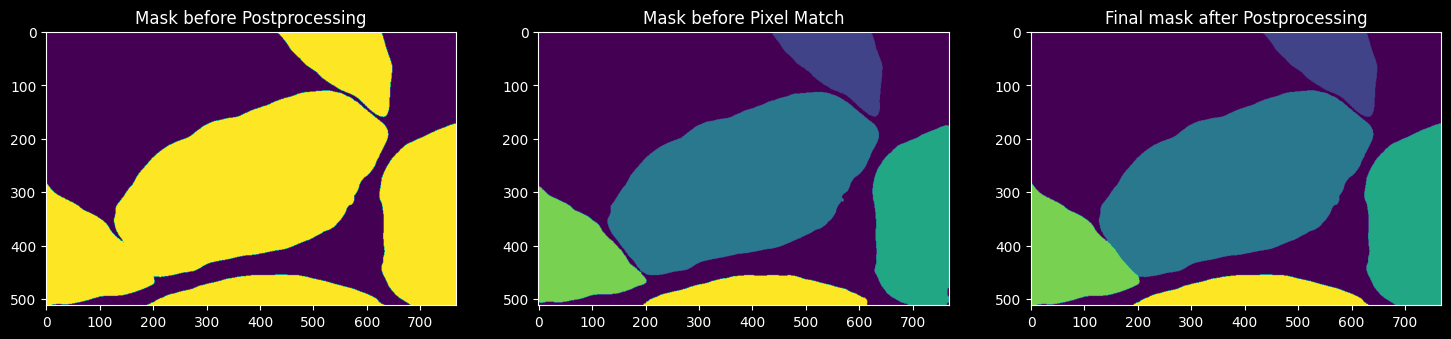

In [9]:
plt.figure(figsize=(18,8))
plt.subplot(1, 3, 1)
plt.title("Mask before Postprocessing")
plt.imshow(ori_mask)

plt.subplot(1, 3, 2)
plt.title("Mask before Pixel Match")
plt.imshow(labeled_mask)

plt.subplot(1, 3, 3)
plt.title("Final mask after Postprocessing")
plt.imshow(opened_image)

We can save the segmented organelle instance to the hard drive

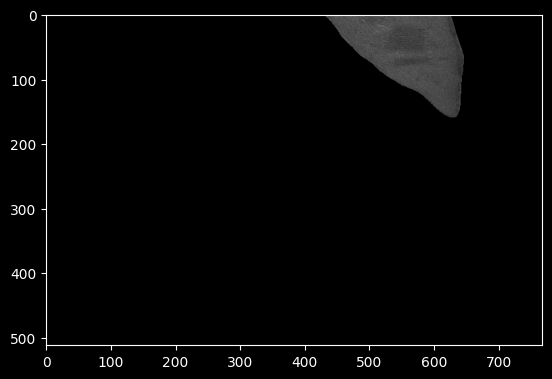

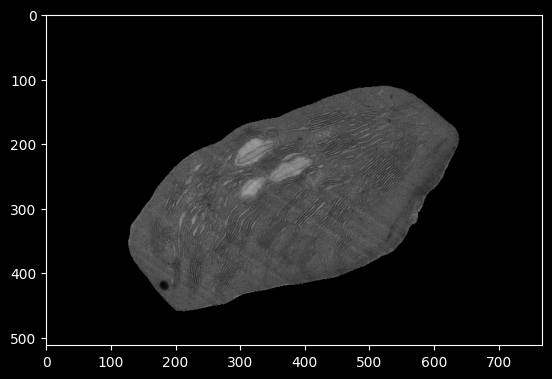

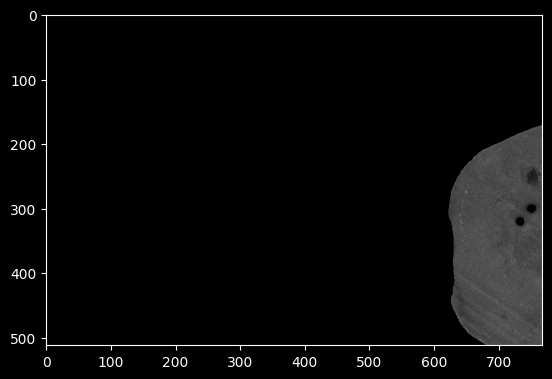

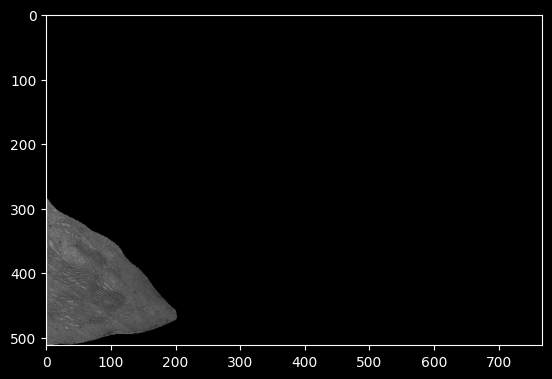

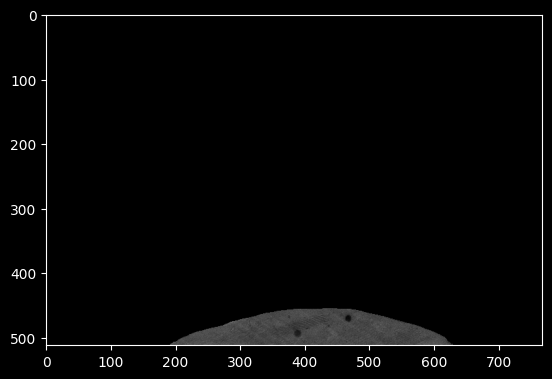

In [10]:
import cv2
separated_regions = []
image = rgb_img
# save all mask in masks
masks = []
# save all predict coordings for all masks
predict_coord = []
for label in range(1, num_labels + 1):
    mask = np.uint8(opened_image == label)
    # save all mask in masks
    masks.append(mask)
    # find contours for each organelle
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    separated_region = cv2.bitwise_and(image, image, mask=mask)

    # find the bounding box for each organelle
    x, y, w, h = cv2.boundingRect(max_contour)
    x1, y1, x2, y2 = x, y, x+w, y+h
    # draw the bounding box
    # cv2.rectangle(separated_region, (x1, y1), (x2, y2), (255, 0, 0), 3)
    predict_coord.append([x1, y1, x2, y2])

    separated_regions.append(separated_region)

# show and savethe image
for i, region in enumerate(separated_regions):
    Image.fromarray(np.uint8(255*region)).convert("RGB").resize([4800, 3230]).save(r"work_dirs/predicts/" + str(i)+"_Chlo_predict.png")
    plt.figure()
    plt.imshow(region)
    plt.show()